In [1]:
import sys
sys.path.append('../..')
import wandb
from data import load_data
from model_configs import build_model
from sklearn.linear_model import RidgeClassifier
from meco import MECO
from models import GCN, train_lens, test_lens
import os
import joblib
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch_explain as te
from torch.nn.functional import one_hot
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx
from torch.nn.functional import one_hot, leaky_relu


In [2]:
models = ['GCN', 'RF', 'DT']
# models = ['RF', 'DT']

# load data
x, y, is_control, fnames, cnames = load_data(data_path='../../data/MiceProtein.arff')

sss = StratifiedShuffleSplit(n_splits=5, random_state=42)
sss.get_n_splits(x, y)
results = pd.DataFrame([], columns=['Model', 'Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)'])
expl_pd = pd.DataFrame([], columns=['Fold', 'Accuracy (%)', 'Complexity', 'Explanation'])
fimps = {m: np.zeros(x.shape[1]) for m in models}
for split, (train_index, test_index) in enumerate(sss.split(x, y)):
#     if split > 3:
#         break
    for model_name in models:
        model_path = os.path.join('./artifacts', str(split), model_name)
        if model_name == 'GCN':
            expl = joblib.load(os.path.join('./artifacts', str(split), "explanations.pkl"))
#             m = GCN(x.shape[1], 50, len(torch.unique(y)))
            m = torch.load(os.path.join(model_path, "model.pth"))
            fimp = m.lens.alpha_norm.median(dim=0)[0].detach().numpy()
            exp_acc = np.median([e['explanation_accuracy'] for e in expl.values() if isinstance(e, dict)])
            exp_comp = np.sum([e['explanation_complexity'] for e in expl.values() if isinstance(e, dict)])
            results.loc[len(results)] = ['Logic Explained Net', 1-expl['f1'], 1-exp_acc, np.log(exp_comp)]
            cn = np.array(list(set(cnames.values)))
            for c in range(len(np.unique(y))):
                exp = expl[str(c)]
                rule = str(cn[c], 'utf-8') + ' \leftarrow ' + expl[str(c)]['explanation'].replace('&', '\land').replace('|', '\lor').replace('_N', '').replace('~', '\\neg ')
                rule = rule.replace("\n", "")
                print(rule)
                expl_pd.loc[len(expl_pd)] = [f'${split+1}$', f'${exp["explanation_accuracy"].item()*100:.2f}$', f'${exp["explanation_complexity"].item()}$', f'${rule}$']
        elif model_name == 'DT':
            model = joblib.load(os.path.join(model_path, "model.pkl"))
            y_pred = model.predict(x[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            n_nodes = model.tree_.node_count
            fimp = model.feature_importances_
            results.loc[len(results)] = ['Decision Tree', 1-f1, 1-f1, np.log(n_nodes)]
        else:
            model = joblib.load(os.path.join(model_path, "model.pkl"))
            y_pred = model.predict(x[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            fimp = model.feature_importances_
            n_count = 0
            for est in model.estimators_:
                n_count += est.tree_.node_count
            results.loc[len(results)] = ['Random Forest', 1-f1, 1-f1, np.log(n_count)]
        fimps[model_name] = fimps[model_name] + fimp
fimps = pd.DataFrame(fimps)
fimps = fimps / fimps.max(axis=0)
fimps.index = fnames
fimps

t-SC-m \leftarrow pPKCAB \land ERK \land TRKA \land \neg NUMB \land \neg P70S6
t-CS-m \leftarrow pCAMKII \land pPKCAB \land \neg pPKCG
c-SC-m \leftarrow NR2A \land \neg ITSN1 \land \neg pPKCAB \land \neg S6
t-CS-s \leftarrow pCAMKII \land pPKCAB \land \neg GSK3B \land \neg RAPTOR
c-CS-m \leftarrow ITSN1 \land APP \land CaNA \land \neg ELK \land \neg pPKCG
c-SC-s \leftarrow ITSN1 \land pELK \land \neg pPKCAB \land \neg pCASP9
t-SC-s \leftarrow APP \land SOD1 \land \neg ERK \land \neg GluR3 \land \neg SYP
c-CS-s \leftarrow TIAM1 \land pPKCG \land \neg pNR2B \land \neg P70S6 \land \neg SYP
t-SC-m \leftarrow pNR1 \land \neg pCAMKII \land \neg SOD1 \land \neg TIAM1
t-CS-m \leftarrow pRSK \land pNUMB \land CaNA \land \neg pPKCG
c-SC-m \leftarrow SOD1 \land \neg AKT \land \neg pPKCG
t-CS-s \leftarrow pCAMKII \land \neg pELK \land \neg DSCR1 \land \neg AMPKA \land \neg AcetylH3K9
c-CS-m \leftarrow pERK \land APP \land CaNA \land \neg Tau \land \neg pCASP9
c-SC-s \leftarrow BRAF \land \neg ERK 

,GCN,RF,DT
DYRK1A_N,0.000016,0.274507,0.040084
ITSN1_N,0.026753,0.391438,0.059799
BDNF_N,0.000011,0.049968,0.000000
NR1_N,0.277812,0.046921,0.037806
NR2A_N,0.750772,0.044476,0.009651
...,...,...,...
SYP_N,0.000013,0.049055,0.025964
H3AcK18_N,0.000003,0.099252,0.000000
EGR1_N,0.000005,0.021881,0.000000
H3MeK4_N,0.000007,0.034430,0.000000


In [3]:
results

,Model,Model Error (%),Explanation Error (%),Explanation Complexity (log)
0,Logic Explained Net,0.018307,0.013889,3.555348
1,Random Forest,0.092589,0.092589,8.641179
2,Decision Tree,0.177895,0.177895,3.931826
3,Logic Explained Net,0.000000,0.027778,3.496508
4,Random Forest,0.102439,0.102439,8.633019
5,Decision Tree,0.226494,0.226494,4.043051
6,Logic Explained Net,0.000000,0.013889,3.496508
7,Random Forest,0.074156,0.074156,8.647519
8,Decision Tree,0.260845,0.260845,4.007333
9,Logic Explained Net,0.009271,0.023148,3.637586


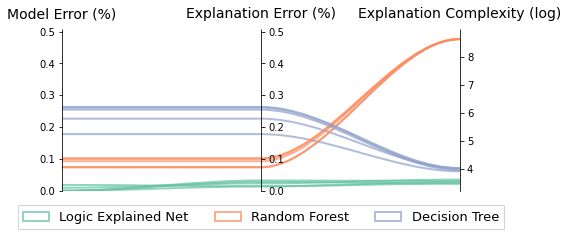

In [4]:
from matplotlib.path import Path
import matplotlib.patches as patches

result_dir = './results/figs_base'
os.makedirs(result_dir, exist_ok=True)

model_id = {'Logic Explained Net': 0, 'Random Forest': 1, 'Decision Tree': 2}
ynames = ['Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)']
ys = results.values[:, 1:]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

# ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
ymaxs[0], ymins[0] = 0.5, 0.
ymaxs[1], ymins[1] = 0.5, 0.
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(8,3.5))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)

my_cmap = matplotlib.colors.ListedColormap(plt.cm.Set2.colors[:3], name='my_colormap_name')
colors = my_cmap.colors
model_ids = [model_id[i] for i in results['Model'].values]
legend_handles = [None for _ in model_ids]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[model_ids[j]])
    legend_handles[model_ids[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, model_id.keys(),
            loc='lower center', bbox_to_anchor=(0.5, -0.28),
            ncol=len(model_id.keys()), fancybox=False, shadow=False, fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'pareto.png'), facecolor='white', transparent=False)
plt.savefig(os.path.join(result_dir, 'pareto.pdf'), facecolor='white', transparent=False)
plt.show()

In [5]:
expl_pd.to_csv(os.path.join(result_dir, 'explanations.csv'))

In [6]:
total = fimps.sum(axis=1)
sort_idx = total.argsort(total)[::-1].values
fimps = fimps.iloc[sort_idx]
fimps.columns = ['Logic Explained Net', 'Random Forest', 'Decision Tree']

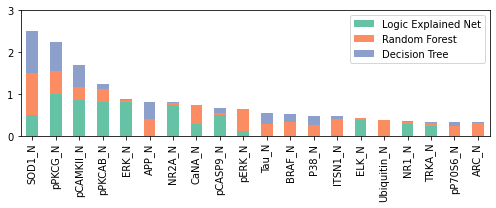

In [7]:
# Plot the total crashes
colors = plt.cm.Set2.colors
# f, ax = plt.subplots(figsize=(6, 18))
sns.set_color_codes("pastel")
# sns.barplot(x=total[sort_idx], y=fn[sort_idx], label="Total", color="b", alpha=0.3)
# sns.barplot(data=feat, stacked=True)
ax = fimps.iloc[:20].plot(kind='bar', stacked=True, figsize=(7, 3), colormap=my_cmap)
ax.set_ylim([0, 3])
ax.set_yticks([0, 1, 2, 3])
# ax.set_yticklabels([0, 1, 2, 3])
# sns.barplot(x=model.feature_importances_[sort_idx], y=fn[sort_idx], label="DT", color=colors[model_id['DT']])
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'feature_importance.png'), facecolor='white', transparent=False)
plt.savefig(os.path.join(result_dir, 'feature_importance.pdf'), facecolor='white', transparent=False)
plt.show()

In [10]:
for i in range(20):
    print(fimps.iloc[:20].index[i])

SOD1_N
pPKCG_N
pCAMKII_N
pPKCAB_N
ERK_N
APP_N
NR2A_N
CaNA_N
pCASP9_N
pERK_N
Tau_N
BRAF_N
P38_N
ITSN1_N
ELK_N
Ubiquitin_N
NR1_N
TRKA_N
pP70S6_N
ARC_N
